# Rank Attack Detection Using ML
## 21i-1578 & 21i-1579

### Feature Preprocessing

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('Rank.csv')

# Drop irrelevant features
unwanted_features = [
    'PACKET_ID', 'SEGMENT_ID', 'TRANSMITTER_ID',
    'RECEIVER_ID', 'APP_LAYER_ARRIVAL_TIME(US)', 'TRX_LAYER_ARRIVAL_TIME(US)',
    'NW_LAYER_ARRIVAL_TIME(US)', 'MAC_LAYER_ARRIVAL_TIME(US)', 'PHY_LAYER_ARRIVAL_TIME(US)',
    'PHY_LAYER_START_TIME(US)', 'PHY_LAYER_END_TIME(US)', 'APP_LAYER_PAYLOAD(Bytes)',
    'TRX_LAYER_PAYLOAD(Bytes)', 'NW_LAYER_PAYLOAD(Bytes)', 'MAC_LAYER_PAYLOAD(Bytes)',
    'PHY_LAYER_PAYLOAD(Bytes)', 'PHY_LAYER_OVERHEAD(Bytes)', 'PACKET_STATUS',
    'LOCAL_ADDRESS', 'REMOTE_ADDRESS', 'CWND', 'SEQ_NO', 'ACK_NO',
    'isSyn', 'isAck', 'isFin', 'SEGMENT_LEN', 'SOURCE_IP', 'DESTINATION_IP',
    'GATEWAY_IP', 'NEXT_HOP_IP', 'Unnamed: 38'
]
df = df.drop(columns=unwanted_features)

# Remove duplicates
df = df.drop_duplicates()

# Handle missing values
df = df.dropna(subset=['RPL_RANK', 'PCKT_LABEL'])  # Critical for modeling
df['CONTROL_PACKET_TYPE/APP_NAME'].fillna('UNKNOWN', inplace=True)
df['RPL_VERSION'].fillna(-1, inplace=True)

# Check: cleaned data
print(df.head())
print(df.isnull().sum())

       PACKET_TYPE CONTROL_PACKET_TYPE/APP_NAME    SOURCE_ID DESTINATION_ID  \
2   Control_Packet                          DIO  SINKNODE-17    Broadcast-0   
7   Control_Packet                          DAO    SENSOR-16    SINKNODE-17   
8   Control_Packet                          DAO     SENSOR-8    SINKNODE-17   
9   Control_Packet                          DIO     SENSOR-8    Broadcast-0   
18  Control_Packet                          DIO    SENSOR-16    Broadcast-0   

    PCKT_LABEL  RPL_RANK  RPL_VERSION  
2          0.0       1.0          0.0  
7          0.0      16.0          0.0  
8          0.0      15.0          0.0  
9          0.0      15.0          0.0  
18         0.0      16.0          0.0  
PACKET_TYPE                     0
CONTROL_PACKET_TYPE/APP_NAME    0
SOURCE_ID                       0
DESTINATION_ID                  0
PCKT_LABEL                      0
RPL_RANK                        0
RPL_VERSION                     0
dtype: int64


C:\Users\Haiqa\AppData\Local\Temp\ipykernel_15896\3556922193.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CONTROL_PACKET_TYPE/APP_NAME'].fillna('UNKNOWN', inplace=True)
C:\Users\Haiqa\AppData\Local\Temp\ipykernel_15896\3556922193.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

### Checking Class Balance

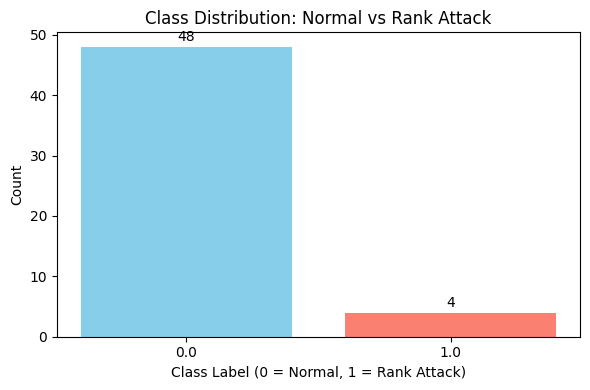

In [3]:
import matplotlib.pyplot as plt

# Get class counts
class_counts = df['PCKT_LABEL'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['skyblue', 'salmon'])
plt.title('Class Distribution: Normal vs Rank Attack')
plt.xlabel('Class Label (0 = Normal, 1 = Rank Attack)')
plt.ylabel('Count')

# Annotate bar values
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Label Encoding

In [4]:
# Identify non-numeric columns
cat_cols = df.select_dtypes(include=['object']).columns

# Apply manual label encoding
for col in cat_cols:
    df[col], _ = pd.factorize(df[col])

# Check if everything is numeric now
print(df.dtypes)

PACKET_TYPE                       int64
CONTROL_PACKET_TYPE/APP_NAME      int64
SOURCE_ID                         int64
DESTINATION_ID                    int64
PCKT_LABEL                      float64
RPL_RANK                        float64
RPL_VERSION                     float64
dtype: object


### OneClass SVM

In [5]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report

# Separate features and labels
X = df.drop(columns='PCKT_LABEL')
y_true = df['PCKT_LABEL']

# Train One-Class SVM only on the majority class (normal)
X_train = X[y_true == 0]

# Fit the model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
oc_svm.fit(X_train)

# Predict on all data
y_pred = oc_svm.predict(X)

# Convert predictions: -1 = anomaly (attack), 1 = normal
y_pred_mapped = [1 if p == -1 else 0 for p in y_pred]  # 1 = attack, 0 = normal

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_mapped)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(y_true, y_pred_mapped, target_names=['Normal (0)', 'Rank Attack (1)'])
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[29 19]
 [ 0  4]]

Classification Report:
                  precision    recall  f1-score   support

     Normal (0)       1.00      0.60      0.75        48
Rank Attack (1)       0.17      1.00      0.30         4

       accuracy                           0.63        52
      macro avg       0.59      0.80      0.52        52
   weighted avg       0.94      0.63      0.72        52



### KMeans Clustering

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Prepare features
X = df.drop(columns='PCKT_LABEL')
y_true = df['PCKT_LABEL']

# Step 2: Fit KMeans with 2 clusters (normal, attack)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Step 3: Determine which cluster is "attack" based on mean RPL_RANK or size
cluster_0_mean = X[cluster_labels == 0]['RPL_RANK'].mean()
cluster_1_mean = X[cluster_labels == 1]['RPL_RANK'].mean()

# Assume higher RPL_RANK → more likely to be an attack (you can adjust this logic)
attack_cluster = 0 if cluster_0_mean > cluster_1_mean else 1

# Step 4: Map cluster labels to attack (1) or normal (0)
y_pred = np.where(cluster_labels == attack_cluster, 1, 0)

# Step 5: Evaluate
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Normal (0)", "Rank Attack (1)"])

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[47  1]
 [ 4  0]]

Classification Report:
                  precision    recall  f1-score   support

     Normal (0)       0.92      0.98      0.95        48
Rank Attack (1)       0.00      0.00      0.00         4

       accuracy                           0.90        52
      macro avg       0.46      0.49      0.47        52
   weighted avg       0.85      0.90      0.88        52



# Graphs

## Distribution of RPL_Rank
##### This plot shows the distribution of RPL_RANK values for normal and attack traffic. It helps visualize how the rank metric differs between the two classes. A clear separation suggests that RPL_RANK is useful for detecting Rank attacks.

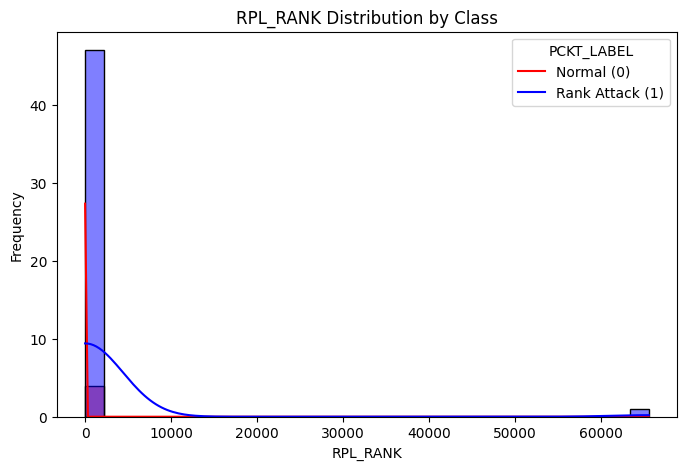

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='RPL_RANK', hue='PCKT_LABEL', bins=30, kde=True, palette=['blue', 'red'])
plt.title('RPL_RANK Distribution by Class')
plt.xlabel('RPL_RANK')
plt.ylabel('Frequency')
plt.legend(title='PCKT_LABEL', labels=['Normal (0)', 'Rank Attack (1)'])
plt.show()

## Correlation Heatmap of Features
##### This heatmap shows the correlation between all numerical features in the dataset. It helps identify relationships and redundancy among features, which can guide feature selection and improve model performance.

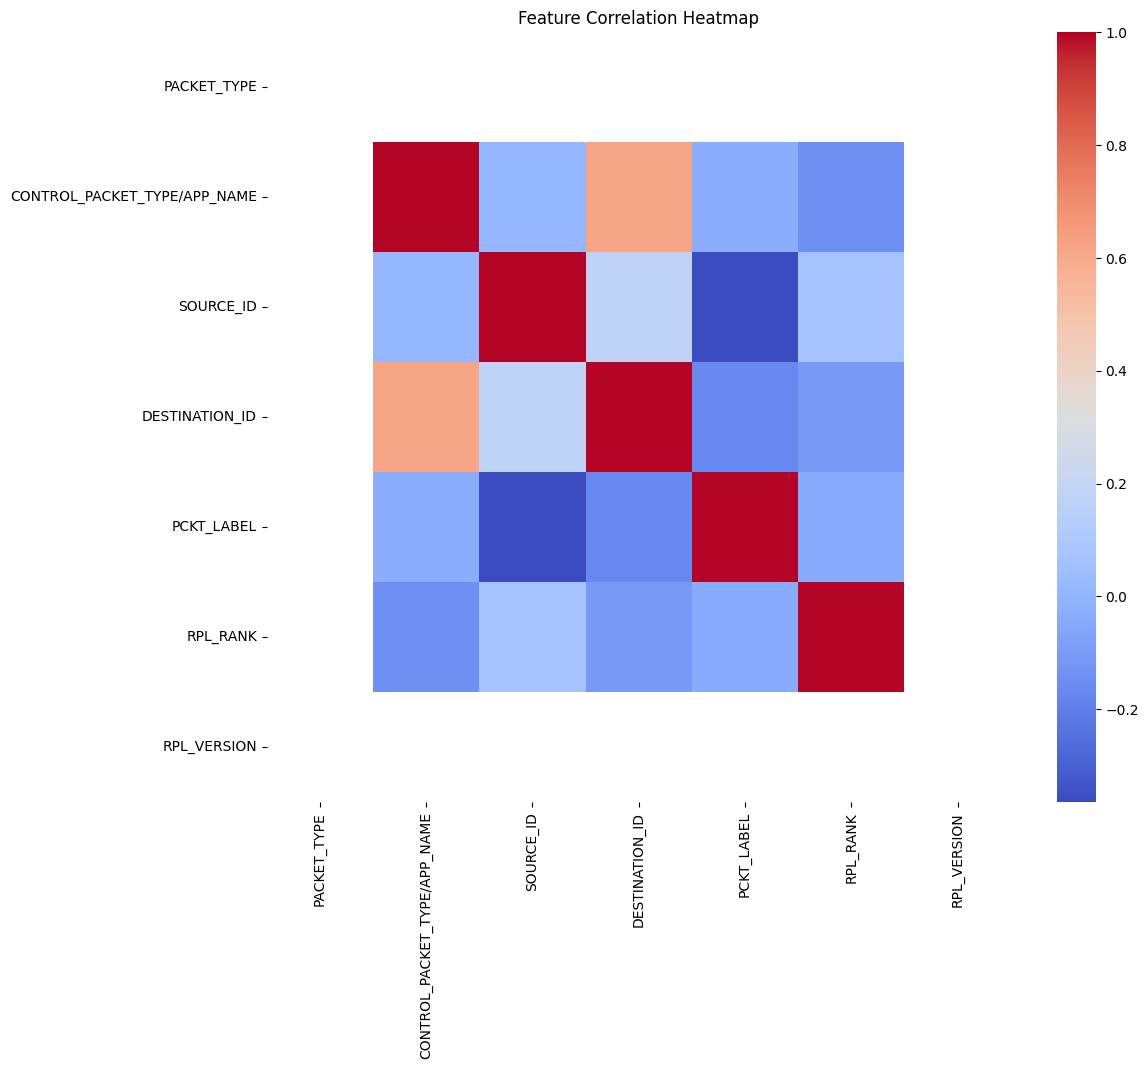

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Confusion Matrix Heatmap (OneClass SVM)
##### This heatmap visualizes the confusion matrix, showing the model's classification performance. It compares true labels with predicted labels, highlighting the number of correct and incorrect predictions for normal and attack traffic.

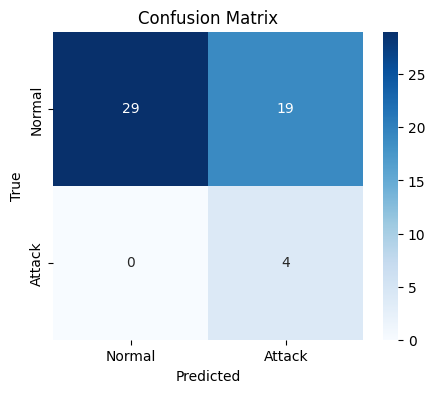

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_mapped)  # or y_pred for KMeans
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## ROC Curve (OneClass SVM)
##### This ROC curve evaluates the One-Class SVM model by plotting the true positive rate against the false positive rate. The area under the curve (AUC) indicates how well the model distinguishes between normal and attack traffic.

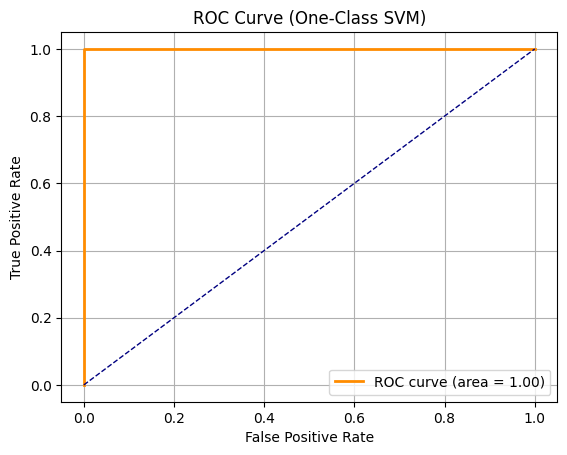

In [12]:
from sklearn.metrics import roc_curve, auc

# If using One-Class SVM (simulate scores with decision_function)
scores = oc_svm.decision_function(X)
fpr, tpr, thresholds = roc_curve(y_true, -scores)  # Flip sign for anomaly = 1
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-Class SVM)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## ROC Curve for KMeans (Distance-Based Score)
##### This ROC curve evaluates KMeans clustering by using the distance to cluster centers as an anomaly score. A higher AUC indicates better separation between normal and attack traffic based on how far points lie from their assigned cluster.

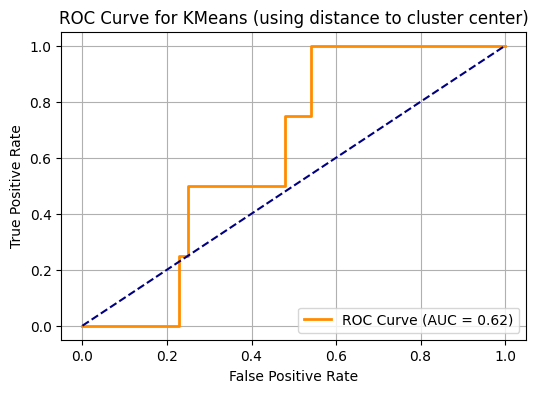

In [14]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate distances from each point to its assigned cluster center
distances = np.linalg.norm(X - kmeans.cluster_centers_[cluster_labels], axis=1)

# Step 2: Higher distance → more likely to be anomaly (attack)
fpr, tpr, _ = roc_curve(y_true, distances)
roc_auc = auc(fpr, tpr)

# Step 3: Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KMeans (using distance to cluster center)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()